In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from datetime import date
from datetime import datetime
from datetime import timedelta

In [2]:
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy import stats as st
from scipy.stats import chi2_contingency
from sklearn.preprocessing import PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

# Project : 
# Mergers and Acquisitions EDA - focus Tech companies 
#                           A strategic perspective:

## Business Questions:

### 1) What is the total number of acquisitions year on year. Did the  number of acquisition increase over the years?

### 2) Which acquiring company is the most active with the highest total number of acquisitions 

### 3) Acquiring companies by acquisition spend. Which company has the highest spend?

### 4) What is the frequency, spend and pattern of acquisitions over the years & in which businesses is MnA concentrated)

### 5) Countries with the highest number of acquisitions acquisition 

### 6) What are the business domains with  the highest acquisition value.

### 7) Are the acquiring companies competing in the same space?

Start with Data exploration and wrangling:

load 2 data sets for comparison and choice of primary set based on higher better data quality:

In [3]:
data= pd.read_csv('acquisitions.csv')
data.head()

,AcquisitionID,AcquisitionMonth,AcquisitionMonthDate,AcquisitionYear,Company,Business,Country,Value (USD),Derived products,ParentCompany
0,ACQ99,November,11.0,2015,bebop,Cloud software,USA,380000000.0,Google Cloud Platform,Google
1,ACQ98,November,11.0,2015,Fly Labs,Video editing,USA,NaN,Google Photos,Google
2,ACQ97,December,8.0,2015,Clearleap,Cloud-based video management,USA,NaN,NaN,IBM
3,ACQ96,December,18.0,2015,Metanautix,Big Data Analytics,USA,NaN,NaN,Microsoft
4,ACQ95,December,21.0,2015,"Talko, Inc.",Mobile communications,USA,NaN,NaN,Microsoft


Exploring null values, proportin and percentage of total:

In [4]:
data.isna().sum()

AcquisitionID             0
AcquisitionMonth          6
AcquisitionMonthDate     33
AcquisitionYear           0
Company                   0
Business                  0
Country                  46
Value (USD)             671
Derived products        515
ParentCompany             0
dtype: int64

In [5]:
len(data), len(data.dropna())

(916, 114)

In percentage:

In [6]:
((data.isna().sum())/len(data))*100

AcquisitionID            0.000000
AcquisitionMonth         0.655022
AcquisitionMonthDate     3.602620
AcquisitionYear          0.000000
Company                  0.000000
Business                 0.000000
Country                  5.021834
Value (USD)             73.253275
Derived products        56.222707
ParentCompany            0.000000
dtype: float64

over 73 % of acquisition price and over 56 % of derived products values are null, followed by country at 5 % and date by 3.6 %

Explore the second data set:

In [7]:
data1= pd.read_excel('acquisitions_update_2021-trial.xlsx')
data1.head()

,ID,Parent Company,Acquisition Year,Acquisition Month,Acquired Company,Business,Country,Acquisition Price,Category,Derived Products
0,1,Apple,1988,Mar,Network Innovations,Software,-,-,-,-
1,2,Apple,1988,Jun,Orion Network Systems,Computer Software,-,-,-,-
2,3,Apple,1988,Jun,Styleware,Computer software,-,-,-,-
3,4,Apple,1988,Jul,Nashoba Systems,Computer software,-,-,-,-
4,5,Apple,1989,Jan,Coral Software,Computer software,-,-,-,-


In [8]:
len(data1), len(data1.dropna())

(1455, 1455)

Although data1 (2 cells above)  has more rows, it also has more null values. it has a lot of '-'values in updated file. These values will be first changed to null values to aid the data quality assessment 

In [9]:
data1=data1.replace('-',np.NaN)

In [10]:
(data1.isna().sum())

ID                      0
Parent Company          0
Acquisition Year       28
Acquisition Month      58
Acquired Company        0
Business              274
Country              1114
Acquisition Price     945
Category             1445
Derived Products     1052
dtype: int64

In percentage:

In [11]:
((data1.isna().sum())/len(data1))*100

ID                    0.000000
Parent Company        0.000000
Acquisition Year      1.924399
Acquisition Month     3.986254
Acquired Company      0.000000
Business             18.831615
Country              76.563574
Acquisition Price    64.948454
Category             99.312715
Derived Products     72.302405
dtype: float64

In [12]:
len(data1), len(data1.dropna())

(1455, 0)

from the cells above, the % of null values are much higher and more spread along the cateogry. In fact, every single row is incomplete as shown from the dataframe length of 0 if all rows with null values are dropped

Given the business questions to be answered while comparing both data sets, the first dataset "data" is the preferred choice as the primary datasetfor the EDA. The second set (data 1) will be used to further enrich the primary dataframe.

First a common column between the 2 dataframes is created.It has to  be unique in nature. 

In [13]:
data1['parent-acquired'] = data1['Parent Company']+'-'+data1['Acquired Company']

In [14]:
data1.head()

,ID,Parent Company,Acquisition Year,Acquisition Month,Acquired Company,Business,Country,Acquisition Price,Category,Derived Products,parent-acquired
0,1,Apple,1988.0,Mar,Network Innovations,Software,NaN,NaN,NaN,NaN,Apple-Network Innovations
1,2,Apple,1988.0,Jun,Orion Network Systems,Computer Software,NaN,NaN,NaN,NaN,Apple-Orion Network Systems
2,3,Apple,1988.0,Jun,Styleware,Computer software,NaN,NaN,NaN,NaN,Apple-Styleware
3,4,Apple,1988.0,Jul,Nashoba Systems,Computer software,NaN,NaN,NaN,NaN,Apple-Nashoba Systems
4,5,Apple,1989.0,Jan,Coral Software,Computer software,NaN,NaN,NaN,NaN,Apple-Coral Software


In [15]:
data['parent-acquired']= data['ParentCompany']+'-'+data['Company']

In [16]:
data.head()

,AcquisitionID,AcquisitionMonth,AcquisitionMonthDate,AcquisitionYear,Company,Business,Country,Value (USD),Derived products,ParentCompany,parent-acquired
0,ACQ99,November,11.0,2015,bebop,Cloud software,USA,380000000.0,Google Cloud Platform,Google,Google-bebop
1,ACQ98,November,11.0,2015,Fly Labs,Video editing,USA,NaN,Google Photos,Google,Google-Fly Labs
2,ACQ97,December,8.0,2015,Clearleap,Cloud-based video management,USA,NaN,NaN,IBM,IBM-Clearleap
3,ACQ96,December,18.0,2015,Metanautix,Big Data Analytics,USA,NaN,NaN,Microsoft,Microsoft-Metanautix
4,ACQ95,December,21.0,2015,"Talko, Inc.",Mobile communications,USA,NaN,NaN,Microsoft,"Microsoft-Talko, Inc."


Next the 2 frames are merged over the common column.Given data is the primary source and to maximize the potential of a bigger complete data set, a left merge is performed. 

In [17]:
data_data1merge = pd.merge(left = data,
                                  right = data1,
                                  how = 'left', 
                                  left_on = "parent-acquired", 
                                  right_on= "parent-acquired")

In [18]:
data_data1merge.isna().sum()

AcquisitionID             0
AcquisitionMonth          6
AcquisitionMonthDate     33
AcquisitionYear           0
Company                   0
Business_x                0
Country_x                46
Value (USD)             671
Derived products        515
ParentCompany             0
parent-acquired           0
ID                      307
Parent Company          307
Acquisition Year        307
Acquisition Month       312
Acquired Company        307
Business_y              374
Country_y               835
Acquisition Price       726
Category                907
Derived Products        705
dtype: int64

In [19]:
data_data1merge=data_data1merge.replace('-',np.NaN)

PE8 Data standarization:

In [20]:
new_cols = []
def column_names(df):
    for i in df.columns:
        x = i.lower().replace(' ','_')
        new_cols.append(x)
    df.columns = new_cols
    display(df.head())
    
column_names(data_data1merge)

,acquisitionid,acquisitionmonth,acquisitionmonthdate,acquisitionyear,company,business_x,country_x,value_(usd),derived_products,parentcompany,...,id,parent_company,acquisition_year,acquisition_month,acquired_company,business_y,country_y,acquisition_price,category,derived_products
0,ACQ99,November,11.0,2015,bebop,Cloud software,USA,380000000.0,Google Cloud Platform,Google,...,611.0,Google,2015.0,Nov,bebop,Cloud software,NaN,380000000,NaN,Google Cloud Platform
1,ACQ98,November,11.0,2015,Fly Labs,Video editing,USA,NaN,Google Photos,Google,...,610.0,Google,2015.0,Nov,Fly Labs,Video editing,NaN,NaN,NaN,Google Photos
2,ACQ97,December,8.0,2015,Clearleap,Cloud-based video management,USA,NaN,NaN,IBM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACQ96,December,18.0,2015,Metanautix,Big Data Analytics,USA,NaN,NaN,Microsoft,...,863.0,Microsoft,2015.0,Dec,Metanautix,Big data analytics,NaN,NaN,NaN,NaN
4,ACQ95,December,21.0,2015,"Talko, Inc.",Mobile communications,USA,NaN,NaN,Microsoft,...,864.0,Microsoft,2015.0,Dec,"Talko, Inc.",Mobile communications,NaN,NaN,NaN,NaN


Data is checked before replacing nulls in 'data' with values in 'data1' were applicable:

In [21]:
data_data1merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acquisitionid         916 non-null    object 
 1   acquisitionmonth      910 non-null    object 
 2   acquisitionmonthdate  883 non-null    float64
 3   acquisitionyear       916 non-null    int64  
 4   company               916 non-null    object 
 5   business_x            916 non-null    object 
 6   country_x             870 non-null    object 
 7   value_(usd)           245 non-null    float64
 8   derived_products      401 non-null    object 
 9   parentcompany         916 non-null    object 
 10  parent-acquired       916 non-null    object 
 11  id                    609 non-null    float64
 12  parent_company        609 non-null    object 
 13  acquisition_year      609 non-null    float64
 14  acquisition_month     604 non-null    object 
 15  acquired_company      6

After reviewing, acquisition value, country and derived product columns going to be enriched from data1 dataset. 

In [22]:
data_data1merge['acquisition_price']=pd.to_numeric(data_data1merge['acquisition_price'], errors='coerce')

In [23]:
list(data_data1merge.columns).index('value_(usd)')

7

In [24]:
list(data_data1merge.columns).index('acquisition_price')

18

In [25]:
na_in_value_indexes=list(data_data1merge[data_data1merge['value_(usd)'].isna()==True].index)

In [26]:
data_data1merge.iloc[na_in_value_indexes,7]=data_data1merge.iloc[na_in_value_indexes,18]


In [27]:
list (data_data1merge.columns).index('country_x')

6

In [28]:
list(data_data1merge.columns).index('country_y')

17

In [29]:
na_in_country_indexes=list(data_data1merge[data_data1merge['country_x'].isna()==True].index)

In [30]:
data_data1merge.iloc[na_in_country_indexes,6]=data_data1merge.iloc[na_in_country_indexes,17]

In [31]:
data_data1merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acquisitionid         916 non-null    object 
 1   acquisitionmonth      910 non-null    object 
 2   acquisitionmonthdate  883 non-null    float64
 3   acquisitionyear       916 non-null    int64  
 4   company               916 non-null    object 
 5   business_x            916 non-null    object 
 6   country_x             875 non-null    object 
 7   value_(usd)           256 non-null    float64
 8   derived_products      401 non-null    object 
 9   parentcompany         916 non-null    object 
 10  parent-acquired       916 non-null    object 
 11  id                    609 non-null    float64
 12  parent_company        609 non-null    object 
 13  acquisition_year      609 non-null    float64
 14  acquisition_month     604 non-null    object 
 15  acquired_company      6

In [32]:
list (data_data1merge.columns)[8]

'derived_products'

However, derived products ended up with the same name making impossible to manipulate like the country and value. 

2 columns with the name derived_products resulting in failure to index NaN value. 

Plan: splice, rename and concatenate back: 

In [33]:
data_data1merge.shape

(916, 21)

In [34]:
data1=data_data1merge.iloc[ : , :-1]

In [35]:
data1.shape

(916, 20)

In [36]:
derived_product=data_data1merge.iloc[ : ,20]

In [37]:
derived_products=pd.DataFrame(derived_product)
derived_products=derived_products.rename(columns={'derived_products':'derived_products_y'})
derived_products

,derived_products_y
0,Google Cloud Platform
1,Google Photos
2,NaN
3,NaN
4,NaN
...,...
911,NaN
912,NaN
913,"Google Play Music, Google Podcasts"
914,NaN


In [38]:
type(derived_products)

pandas.core.frame.DataFrame

In [39]:
data_data1merge=pd.concat([data1,derived_products], axis=1)
data_data1merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acquisitionid         916 non-null    object 
 1   acquisitionmonth      910 non-null    object 
 2   acquisitionmonthdate  883 non-null    float64
 3   acquisitionyear       916 non-null    int64  
 4   company               916 non-null    object 
 5   business_x            916 non-null    object 
 6   country_x             875 non-null    object 
 7   value_(usd)           256 non-null    float64
 8   derived_products      401 non-null    object 
 9   parentcompany         916 non-null    object 
 10  parent-acquired       916 non-null    object 
 11  id                    609 non-null    float64
 12  parent_company        609 non-null    object 
 13  acquisition_year      609 non-null    float64
 14  acquisition_month     604 non-null    object 
 15  acquired_company      6

Now the process of replacing null values in 'derived_product' can proceed:

In [40]:
na_in_derivedproducts_indexes=list(data_data1merge[data_data1merge['derived_products'].isna()==True].index)

In [41]:
data_data1merge.iloc[na_in_derivedproducts_indexes,8]=data_data1merge.iloc[na_in_derivedproducts_indexes,20]

And the same for the date:

In [42]:
na_in_acquistionmonth_indexes=list(data_data1merge[data_data1merge['acquisitionmonth'].isna()==True].index)
data_data1merge.iloc[na_in_acquistionmonth_indexes,1]=data_data1merge.iloc[na_in_acquistionmonth_indexes,14]

In [43]:
data_data1merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acquisitionid         916 non-null    object 
 1   acquisitionmonth      910 non-null    object 
 2   acquisitionmonthdate  883 non-null    float64
 3   acquisitionyear       916 non-null    int64  
 4   company               916 non-null    object 
 5   business_x            916 non-null    object 
 6   country_x             875 non-null    object 
 7   value_(usd)           256 non-null    float64
 8   derived_products      402 non-null    object 
 9   parentcompany         916 non-null    object 
 10  parent-acquired       916 non-null    object 
 11  id                    609 non-null    float64
 12  parent_company        609 non-null    object 
 13  acquisition_year      609 non-null    float64
 14  acquisition_month     604 non-null    object 
 15  acquired_company      6

All useful data from the merge operation has been extracted. It is time to drop off the extra redundant columns, clean and rename the retained colums:

In [44]:
dataprecleaning=data_data1merge.iloc[ : , : 11]

In [45]:
dataprecleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acquisitionid         916 non-null    object 
 1   acquisitionmonth      910 non-null    object 
 2   acquisitionmonthdate  883 non-null    float64
 3   acquisitionyear       916 non-null    int64  
 4   company               916 non-null    object 
 5   business_x            916 non-null    object 
 6   country_x             875 non-null    object 
 7   value_(usd)           256 non-null    float64
 8   derived_products      402 non-null    object 
 9   parentcompany         916 non-null    object 
 10  parent-acquired       916 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 85.9+ KB


Standardizing column names:

In [46]:
dataprecleaning=dataprecleaning.rename(columns={'acquisitionid':'acquisition_id','acquisitionmonth':'acquisition_month',\
                                                'acquisitionmonthdate':'acquisition_monthdate','acquisitionyear':'acquisition_year',\
                                                'company':'acquired_company','business_x':'business','country_x':'country',\
                                                'value_(usd)':'acquistion_price(mil_usd)','parentcompany':'acquiring_company'})

Now replacing null values in the mergerd enriched dataframe:

In [47]:
dataprecleaning['country']=dataprecleaning['country'].fillna('other') # will be revisited later on according to need

In [48]:
dataprecleaning['derived_products']=dataprecleaning['derived_products'].fillna('unclear')# not all strategic intent is made bare!

In [49]:
dataprecleaning['acquisition_monthdate'].mode()[0]

1.0

In [50]:
dataprecleaning['acquisition_monthdate'] = dataprecleaning['acquisition_monthdate'].fillna(dataprecleaning['acquisition_monthdate'].mode()[0])

In [51]:
dataprecleaning['acquisition_month'].mode()

0    June
Name: acquisition_month, dtype: object

In [52]:
dataprecleaning['acquisition_month'] = dataprecleaning['acquisition_month'].fillna(dataprecleaning['acquisition_month'].mode()[0])

Dividing acquistion value by 1 MUSD for processesing time and easy management:

In [53]:
dataprecleaning['acquistion_price(mil_usd)']=(dataprecleaning['acquistion_price(mil_usd)'])/1000000

In [54]:
dataprecleaning.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   acquisition_id             916 non-null    object 
 1   acquisition_month          916 non-null    object 
 2   acquisition_monthdate      916 non-null    float64
 3   acquisition_year           916 non-null    int64  
 4   acquired_company           916 non-null    object 
 5   business                   916 non-null    object 
 6   country                    916 non-null    object 
 7   acquistion_price(mil_usd)  256 non-null    float64
 8   derived_products           916 non-null    object 
 9   acquiring_company          916 non-null    object 
 10  parent-acquired            916 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 85.9+ KB


Now the data is cleared from NaN. Time to glean insight frome data and answer the business questions:

In [55]:
dataprecleaning['acquiring_company'].unique()

array(['Google', 'IBM', 'Microsoft', 'Apple', 'Facebook', 'Yahoo',
       'Twitter'], dtype=object)

In [56]:
data=dataprecleaning.copy()

### 1) What is the total number of acquistions year on year. Did the  number of acquisitions increase over the years?

### Annual Number of acquistions: 

Investigating the available acquisition data for the last year reported in the data ( year 2018) :

In [57]:
data[data['acquisition_year']==2018]

,acquisition_id,acquisition_month,acquisition_monthdate,acquisition_year,acquired_company,business,country,acquistion_price(mil_usd),derived_products,acquiring_company,parent-acquired
359,ACQ6,January,2.0,2018,Buddybuild,Feedback Platform for Development teams,CAN,NaN,"Xcode, TestFlight",Apple,Apple-Buddybuild
470,ACQ5,January,23.0,2018,Confirm,Government Issued ID Verification Platform,USA,NaN,unclear,Facebook,Facebook-Confirm
581,ACQ4,January,29.0,2018,Playfab,Gaming backend service,USA,NaN,unclear,Microsoft,Microsoft-Playfab
692,ACQ3,March,12.0,2018,Texture,Digital magazine subscription service,USA,NaN,News,Apple,Apple-Texture
803,ACQ2,March,27.0,2018,Tenor,GIF image search,USA,NaN,Google Images,Google,Google-Tenor
914,ACQ1,May,18.0,2018,Semantic Machines,Conversational AI,USA,400.0,unclear,Microsoft,Microsoft-Semantic Machines
915,AcQ916,June,4.0,2018,Github,Version Control Hosting,USA,7500.0,unclear,Microsoft,Microsoft-Github


Data runs only until end of Q2 2018. if displayed, it will provided incorrect insight about the state of affairs in 2018 and potential trends as a result. Hence, 2018 data will not be considered for the analysis. It is filtered out as follows:

In [58]:
data=data[data['acquisition_year']!=2018]

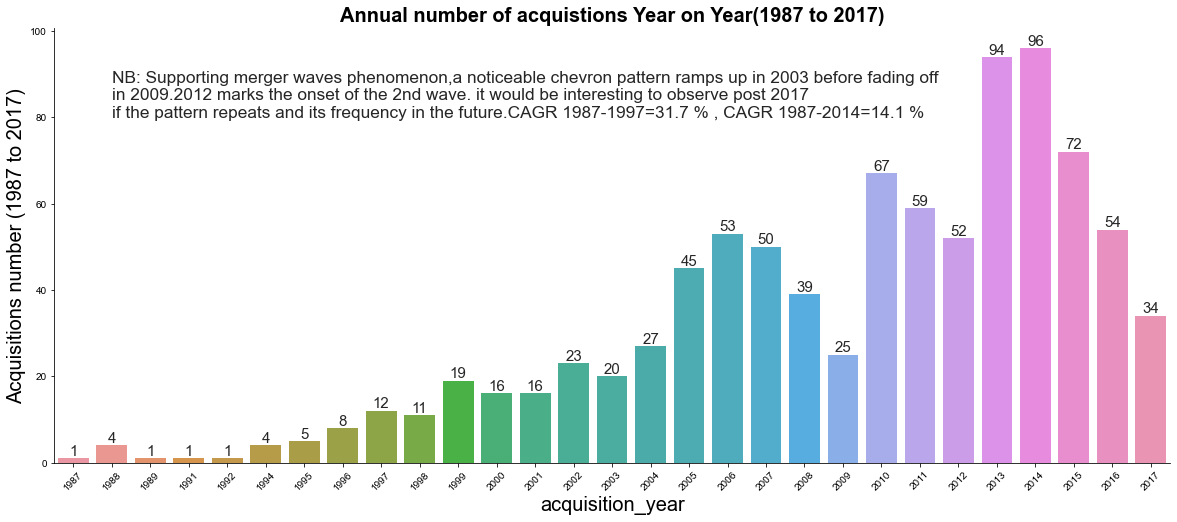

In [59]:
plt.figure(figsize = (20,8))
ax=sns.countplot(x='acquisition_year',data=data)
plt.title("Annual number of acquistions Year on Year(1987 to 2017)",fontsize=20, fontweight="bold")
plt.xlabel('acquisition_year', fontsize=20)
plt.ylabel("Acquisitions number (1987 to 2017)", fontsize=20)
sns.despine()
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
sns.set_style("ticks")
plt.xticks(rotation=45)
text = ('NB: Supporting merger waves phenomenon,a noticeable chevron pattern ramps up in 2003 before fading off' 
        + '\n' + 'in 2009.2012 marks the onset of the 2nd wave. it would be interesting to observe post 2017' + 
        '\n' + 'if the pattern repeats and its frequency in the future.CAGR 1987-1997=31.7 % , CAGR 1987-2014=14.1 %' )
plt.text(x=1, y=80, s=text, size='xx-large')
for container in ax.containers: 
    ax.bar_label(container,fontsize=15);

The following plot sort years in order number of acquistions:

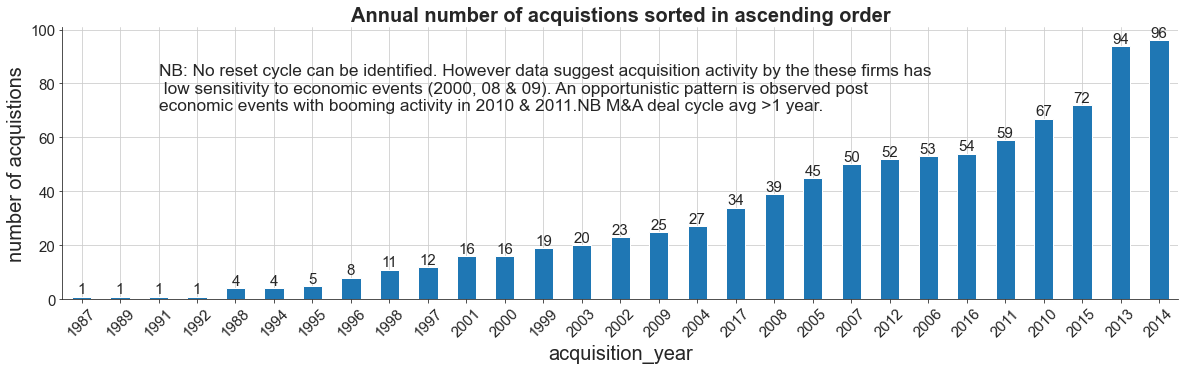

In [60]:
plt.figure(figsize = (20,5))
ax=data['acquisition_year'].value_counts(sort = True,ascending=True).plot.bar(grid = True) 
plt.title("Annual number of acquistions sorted in ascending order", fontsize=20, fontweight='bold')
plt.xlabel("acquisition_year",fontsize=20)
plt.ylabel("number of acquistions",fontsize=20)
sns.despine()
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xticks(rotation=45)
sns.set_style("ticks")
text = ('NB: No reset cycle can be identified. However data suggest acquisition activity by the these firms has' 
        + '\n' + ' low sensitivity to economic events (2000, 08 & 09). An opportunistic pattern is observed post ' + 
        '\n' + 'economic events with booming activity in 2010 & 2011.NB M&A deal cycle avg >1 year.')

plt.text(x=2, y=70, s=text, size='xx-large')
for container in ax.containers: 
    ax.bar_label(container,fontsize=15);
plt.show()

### 2) Acquiring company with the highest total number of acquisitions 

In [61]:
company_acquisitions=data['acquiring_company'].value_counts().reset_index()
company_acquisitions=company_acquisitions.rename(columns={'index':'Acquiring Company', 'acquiring_company':'Acquisitions (1987 to 2017)'})
company_acquisitions

,Acquiring Company,Acquisitions (1987 to 2017)
0,Google,214
1,Microsoft,207
2,IBM,162
3,Yahoo,114
4,Apple,93
5,Facebook,66
6,Twitter,53


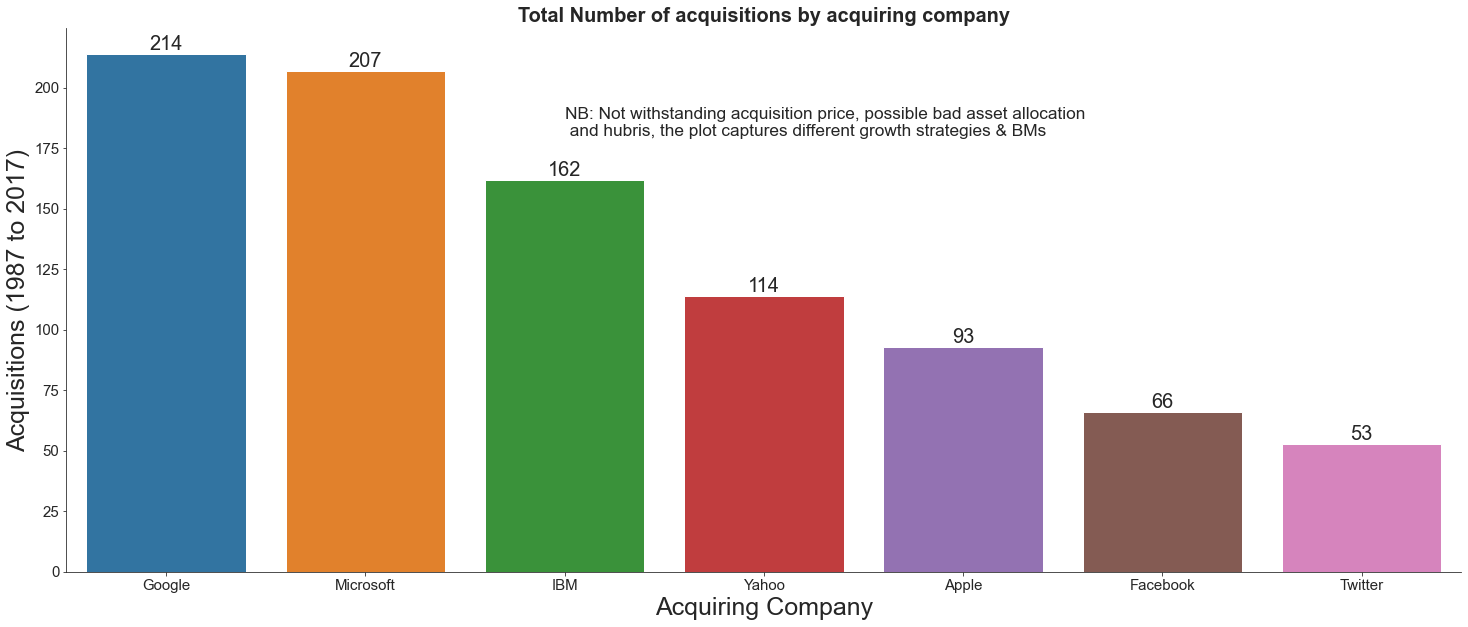

In [62]:
plt.figure(figsize=(25,10))
ax=sns.barplot(x='Acquiring Company', y='Acquisitions (1987 to 2017)', data=company_acquisitions)
plt.title('Total Number of acquisitions by acquiring company',fontsize=20, fontweight="bold")
plt.xlabel('Acquiring Company', fontsize=25)
plt.ylabel("Acquisitions (1987 to 2017)", fontsize=25)
sns.despine()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=15)
sns.set_style("ticks")
text = ('NB: Not withstanding acquisition price, possible bad asset allocation' 
        + '\n' + ' and hubris, the plot captures different growth strategies & BMs')

plt.text(x=2, y=180, s=text, size='xx-large')
for container in ax.containers: 
    ax.bar_label(container,fontsize=20)
plt.show();

### 3) Acquiring companies by acquisition spend. Which company has the highest spend?

In [63]:
#data.columns

In [64]:
companytotalacquisitionprice=(data.groupby("acquiring_company").agg({"acquistion_price(mil_usd)": sum})).reset_index()
companytotalacquisitionprice=companytotalacquisitionprice.rename(columns={'index':'Acquiring Company'})\
.sort_values("acquistion_price(mil_usd)", ascending= False).reset_index(drop=True)

companytotalacquisitionprice

,acquiring_company,acquistion_price(mil_usd)
0,Microsoft,63097.064
1,IBM,36268.000
2,Google,30277.200
3,Facebook,22624.700
4,Yahoo,18097.100
5,Apple,7080.426
6,Twitter,1668.170


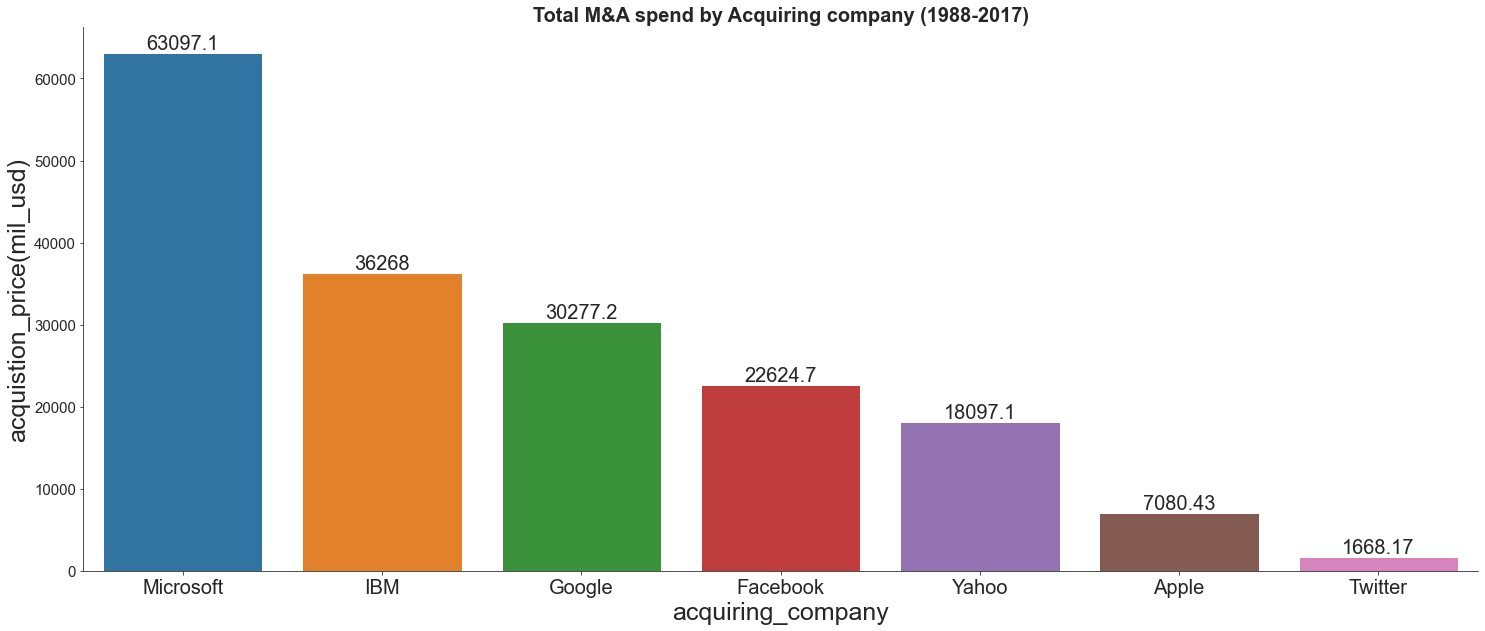

In [65]:
plt.figure(figsize=(25,10))
ax=sns.barplot(x='acquiring_company', y='acquistion_price(mil_usd)', data=companytotalacquisitionprice)
plt.title('Total M&A spend by Acquiring company (1988-2017)',fontsize=20, fontweight="bold")
plt.xlabel('acquiring_company', fontsize=25)
plt.ylabel("acquistion_price(mil_usd)", fontsize=25)
sns.despine()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
sns.set_style("ticks")

for container in ax.containers: 
    ax.bar_label(container,fontsize=20)
plt.show();    

Given the last 2 plots, it seems IBM acquisition has the lowest value added from acquistion reflected on adjusted EBITDA vs the likes of google. Apple arguably commands the highest performance given the market value. this is fallacy though given the differet growth strategy adopted by Apple. Microsoft hovers over the rest at double the total acquisition spend. The age of teh company, its positioning and business model may suggest both the ability and capability to make the amount and size of deals. Nevertheless, These charts may help explain the varrying market sentiment and reaction on news of any acquisition deal in the making by one of these players.  

In [66]:
data.to_csv('week5projectdata.csv')

In [67]:
acq_price_yoy=(data.groupby(["acquiring_company",'acquisition_year']).agg({"acquistion_price(mil_usd)": sum})).reset_index()
acq_price_yoy=acq_price_yoy.rename(columns={'index':'Acquiring Company'})

In [68]:
acq_price_yoy.shape

(119, 3)

In [69]:
acq_price_yoy.head()

,acquiring_company,acquisition_year,acquistion_price(mil_usd)
0,Apple,1988,0.000
1,Apple,1989,0.000
2,Apple,1997,514.000
3,Apple,1999,19.926
4,Apple,2000,0.000


### 4) What is the frequency, spend and pattern of acquisitions over the years & in which businesses is MnA concentrated

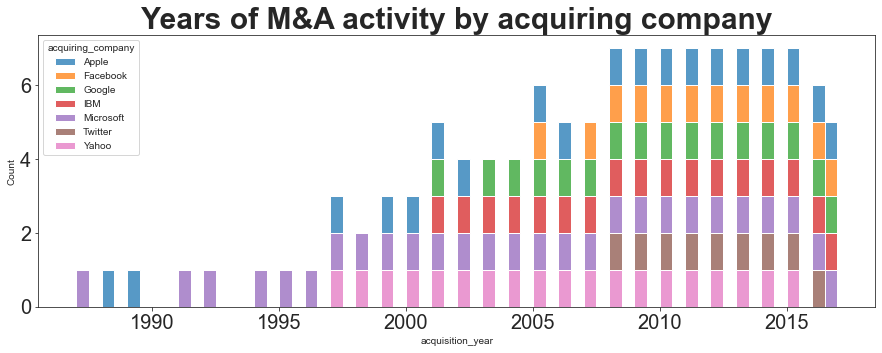

In [70]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5)) 
plt.title('Years of M&A activity by acquiring company',fontsize=30, fontweight="bold")
sns.histplot(binwidth=0.5, x="acquisition_year", hue="acquiring_company", data=acq_price_yoy, stat="count", multiple="stack");

The plot above only chose the years of activity by each of the acquiring companies.

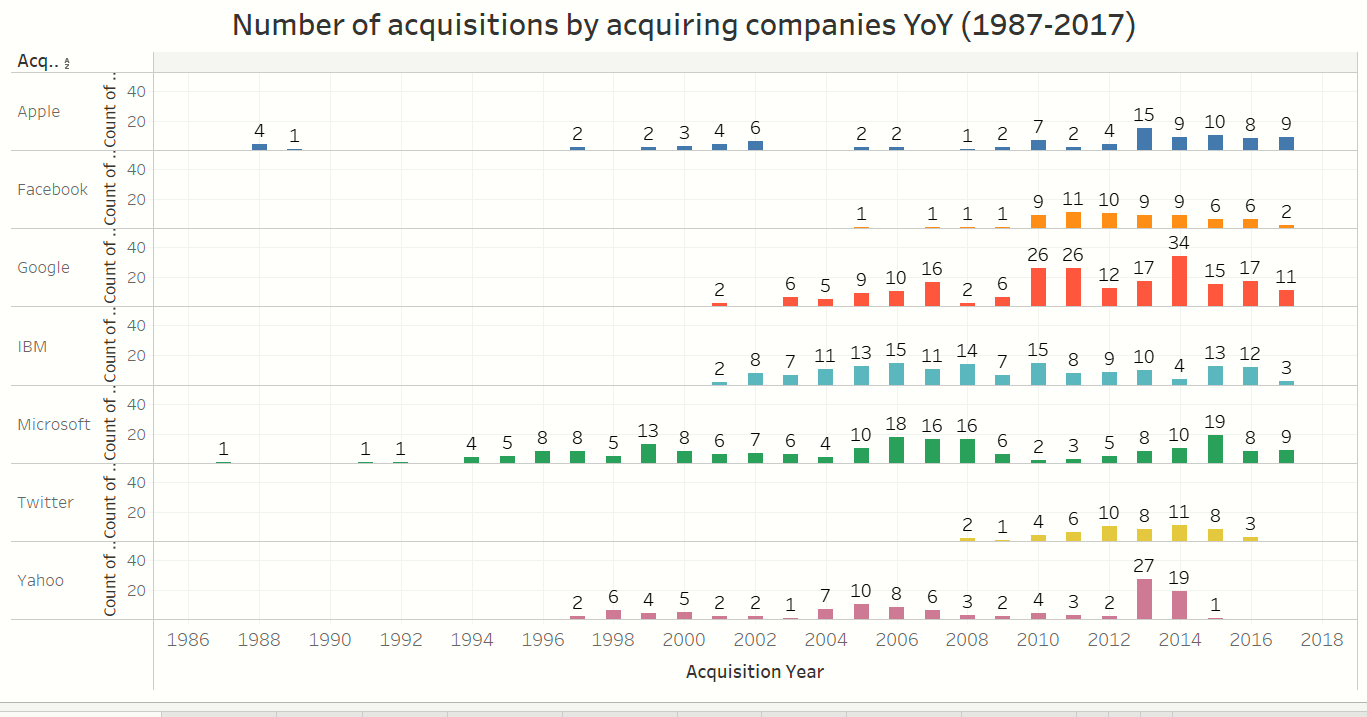

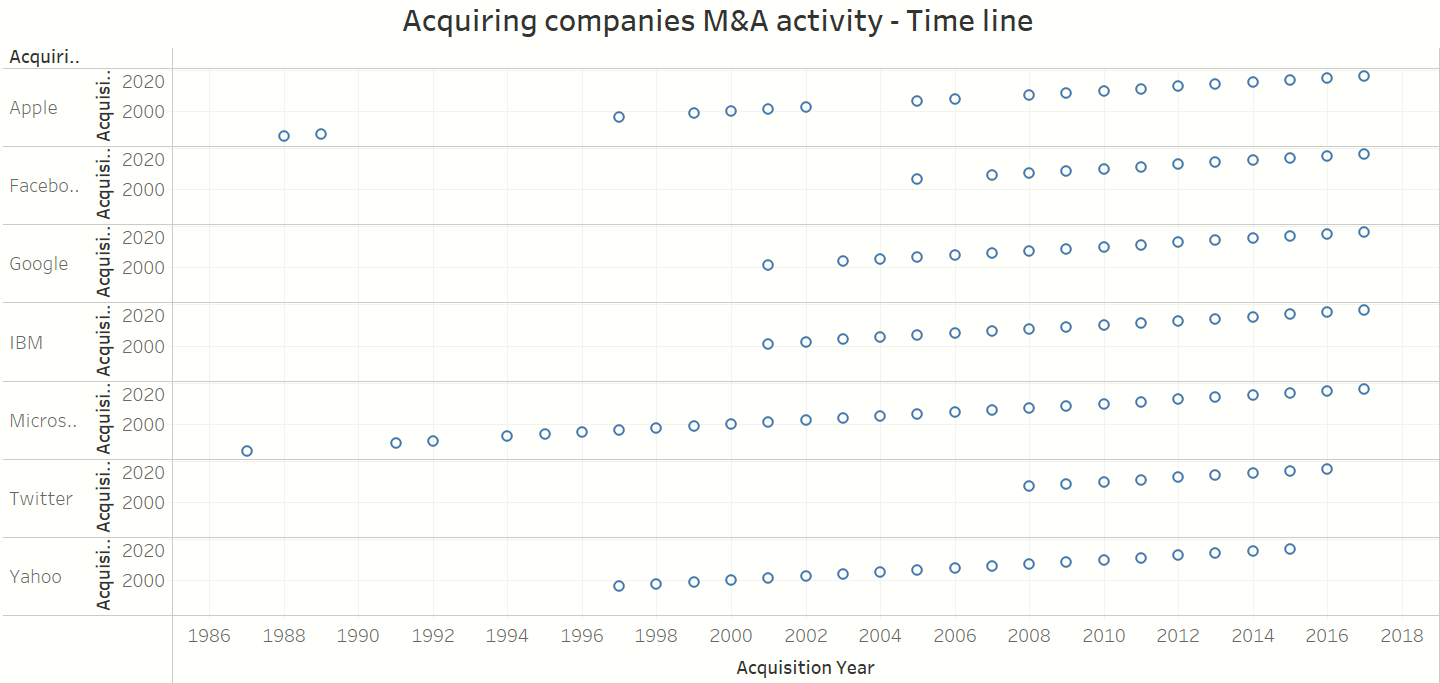

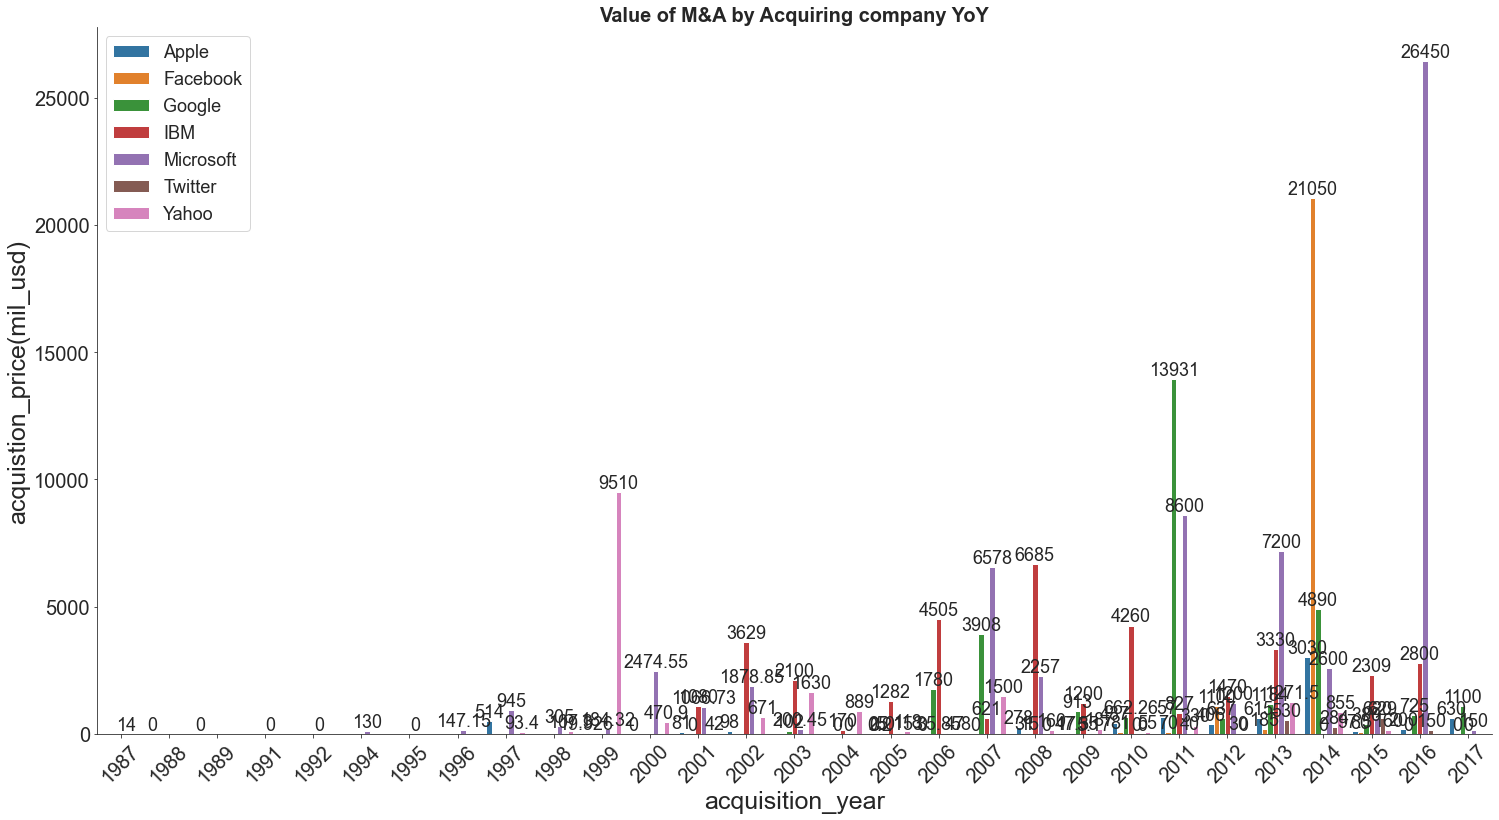

In [71]:
plt.figure(figsize=(25,13))
ax=sns.barplot(x='acquisition_year', y='acquistion_price(mil_usd)', hue="acquiring_company",data=acq_price_yoy)
plt.title('Value of M&A by Acquiring company YoY',fontsize=20, fontweight="bold")
plt.xlabel('acquisition_year', fontsize=25)
plt.ylabel("acquistion_price(mil_usd)", fontsize=25)
sns.despine()

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.xticks(rotation=45)
#sns.set_style("ticks")
plt.legend(prop={'size': 18}, loc=2) # legend position

# code for label values. 
for container in ax.containers: 
    ax.bar_label(container,fontsize=18)
plt.show();

In [72]:
company_acq_price_by_year = data.groupby(["acquiring_company",'acquisition_year']).agg({"acquistion_price(mil_usd)": sum})
company_acq_price_by_year.reset_index()

,acquiring_company,acquisition_year,acquistion_price(mil_usd)
0,Apple,1988,0.000
1,Apple,1989,0.000
2,Apple,1997,514.000
3,Apple,1999,19.926
4,Apple,2000,0.000
...,...,...,...
114,Yahoo,2011,330.000
115,Yahoo,2012,0.000
116,Yahoo,2013,1271.500
117,Yahoo,2014,855.000


In [73]:
company_acq_price_by_year.to_csv('company_acitivity2.csv')


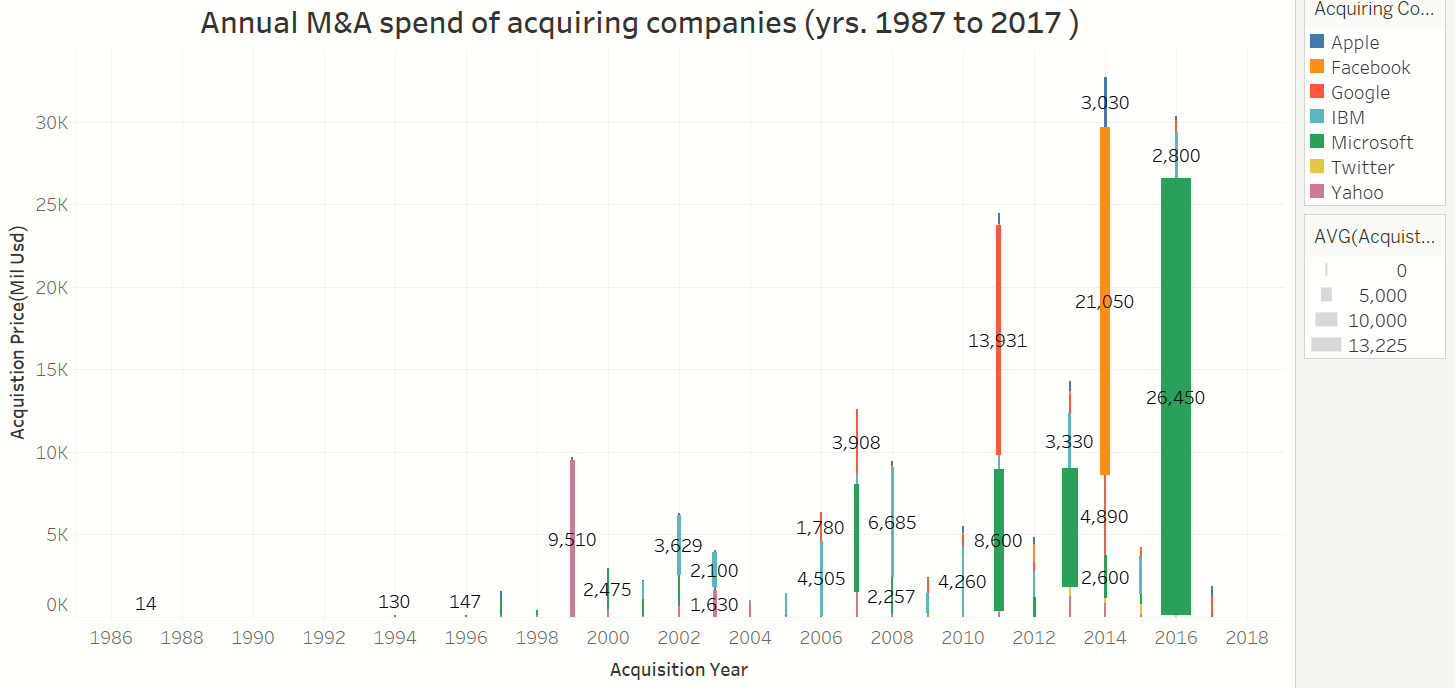

###  In which businesses is MnA acitity concentrated ( the highest)?

In [74]:
data.columns

Index(['acquisition_id', 'acquisition_month', 'acquisition_monthdate',
       'acquisition_year', 'acquired_company', 'business', 'country',
       'acquistion_price(mil_usd)', 'derived_products', 'acquiring_company',
       'parent-acquired'],
      dtype='object')

In [75]:
business_domain = data["business"].value_counts().reset_index()
business_domain = business_domain.rename({"index": "business domain", "business": "Number of Companies acquired"}, axis=1)
Top35_business_domains = business_domain.head(34) # 35 was run to capture all companies by business with 3 aquistions.
Top35_business_domains


,business domain,Number of Companies acquired
0,Software,47
1,Internet software,9
2,Internet service provider,8
3,Online advertising,8
4,Mobile software,7
5,Advertising,7
6,Computer software,7
7,Web search engine,5
8,IT Services,5
9,Maps,5


Some of the most interesting and mission critical acquisitions by business domain are of small count. Note. low number of acquisitions in a domain niether reflect the size of the acquisition nor the critical importance of the acquisition to the competitive position of the acquiring company. It does however shed light on the underlying competition in the respective domains, the associated innovation level and barriers to entry and mimic within these domain, the demand for such services (not the dollar value) and willingness of sale (market growth potential versus the price offered).With a detailed study of the acquiring companies corporate, business unit and operations strategy, valuable insight is gained as to the reasons behind the acquisition size and number. Hence the data herein is to be crossexamined against a top down analysis of the acquiring companies.typically the higher the number of acquisitions in a business domain within a time frame the lower the per acquisition value given limited resources. 

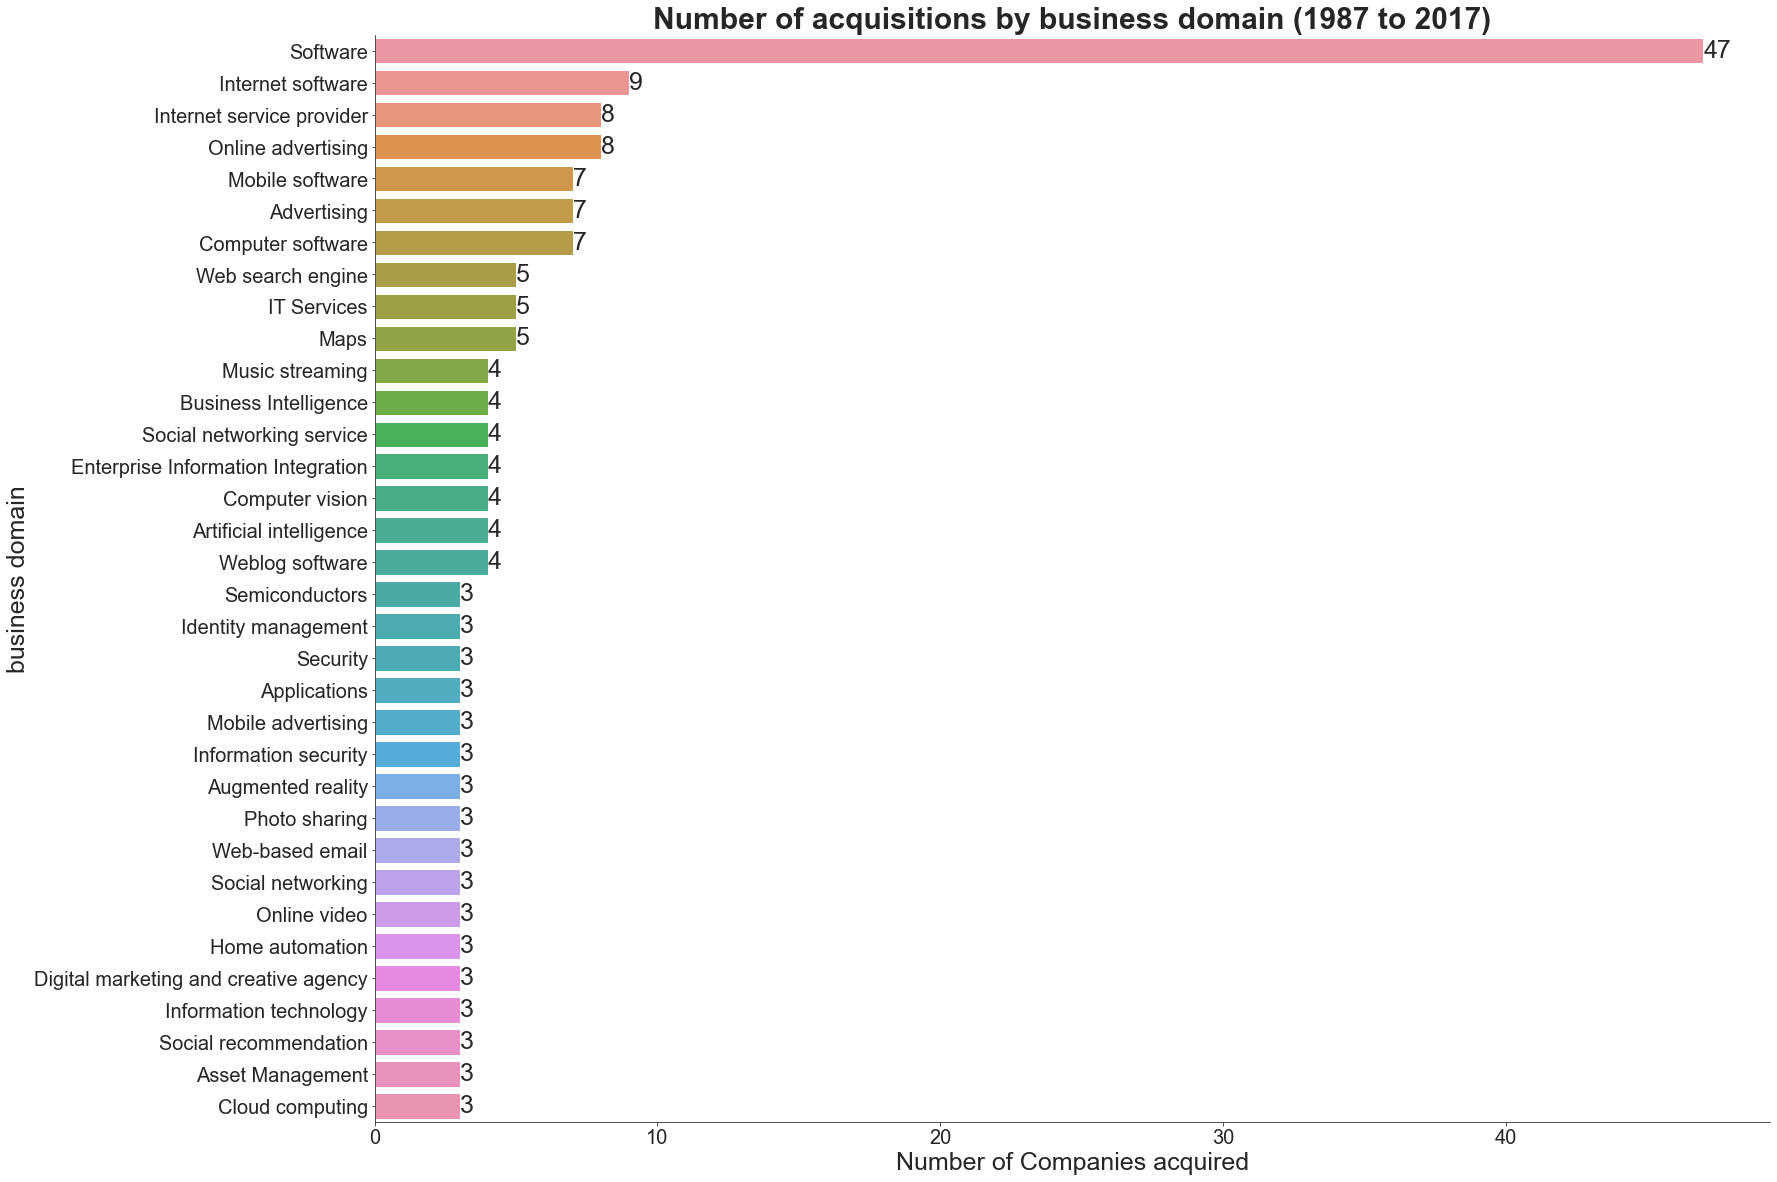

In [76]:
plt.figure(figsize=(25,20))
ax=sns.barplot(x='Number of Companies acquired', y='business domain', data=Top35_business_domains)
plt.title('Number of acquisitions by business domain (1987 to 2017)',fontsize=30, fontweight="bold")
plt.xlabel('Number of Companies acquired', fontsize=25)
plt.ylabel("business domain", fontsize=25)
sns.despine()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=25)
sns.set_style("ticks")


# code for label values. 
for container in ax.containers: 
    ax.bar_label(container,fontsize=25)
plt.show();

In [77]:
Top35_business_domains.to_csv('Top35_business_domains.csv')

The plot above shows insufficient information. it is important to analyze data by the acquiring company interests in the business domain . The following plots in Tableau is portrays business domains with 3 or more acquisition by any of the acquiring companies :

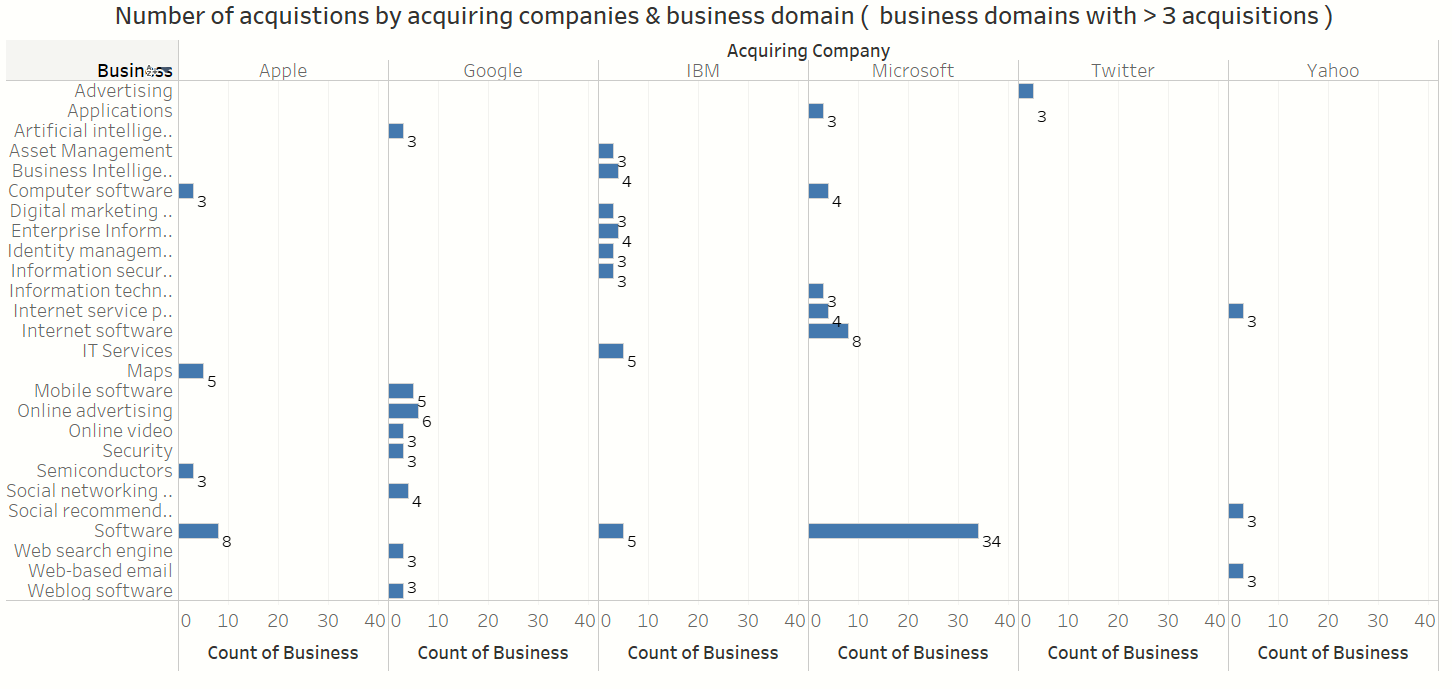

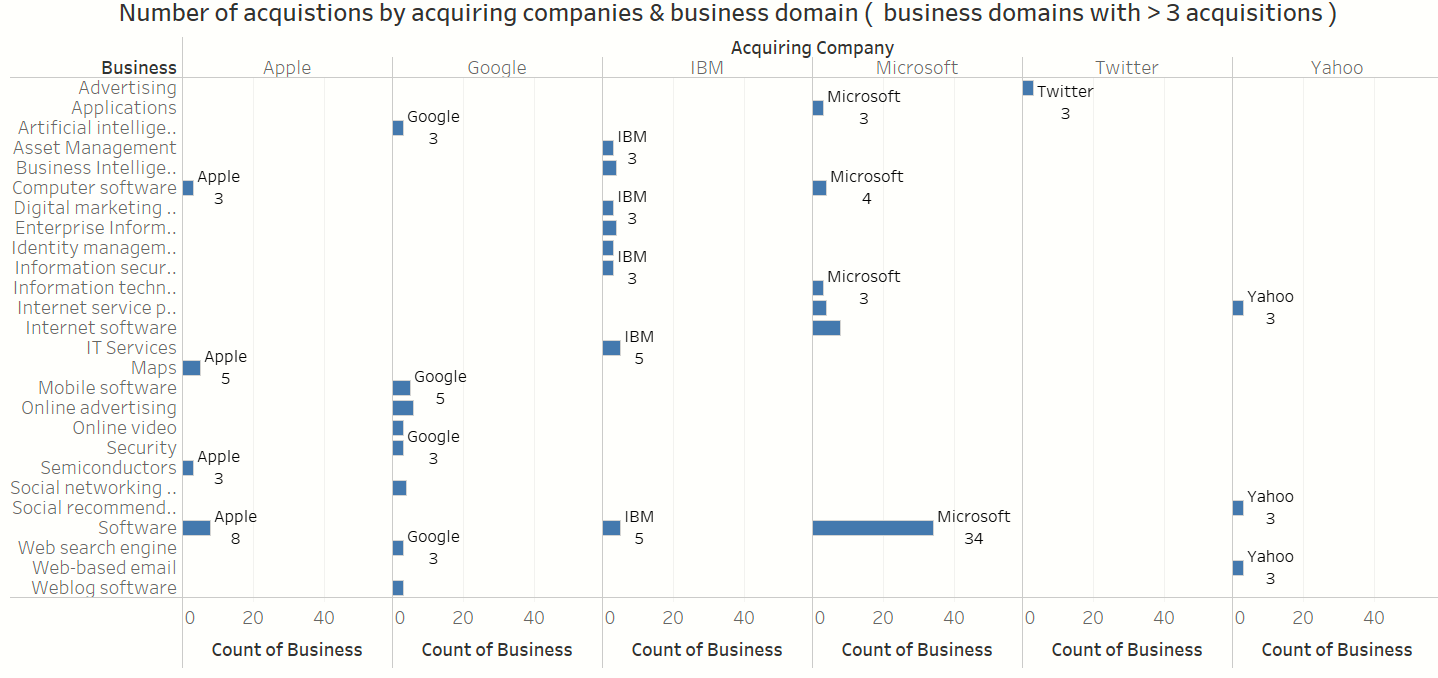

From the plots above, it seems that the acquiring companies business do not overlap as their interests in the business domains are not the same. This is not entirely true though ( especially in the future) as we will see later answering business question number 7

### 5) Countries with the highest number of acquisitions acquisition

Country data is scrutinized, anomalies removed and tracked down unknown acquisition one by one. 
The following cell run through the process of cleaning and enrichment of the country data for maximum accuracy and quality 

In [78]:
data['country'].unique()

array(['USA', 'GER', 'FIN', 'CAN', 'UK', 'SWE', 'ISR', 'TWN', 'AUS',
       'SGP', 'NOR', 'DEN', 'ROU', 'CHN', 'EU', 'IND', 'BLR', 'FRA',
       'BRA', 'ITA', 'SWI', 'SUI', 'CHE', 'NED', 'ESP', 'THA', 'BEL',
       'POR', 'United States', 'KOR', 'other', 'HKG', 'JOR', 'MYS', 'IRL',
       'IDN', 'GRE', 'LUX', 'UKR', 'AUT', 'JPN', 'NZL'], dtype=object)

The missing countries were tracked one by one and updated accordingly as follows:

In [79]:
data['country']= data['country'].apply(lambda x: 'USA' if x == 'United States'  else ('SUI' if x == 'SWI' else x))


In [80]:
#data['country'].value_counts()
data.reset_index(drop=True, inplace=True)
data.iloc[460:470,:]

,acquisition_id,acquisition_month,acquisition_monthdate,acquisition_year,acquired_company,business,country,acquistion_price(mil_usd),derived_products,acquiring_company,parent-acquired
460,ACQ507,May,24.0,2010,Sterling Commerce,Business software integration,USA,1400.0,unclear,IBM,IBM-Sterling Commerce
461,ACQ506,May,25.0,2010,Koprol,Geosocial network,IDN,NaN,Koprol,Yahoo,Yahoo-Koprol
462,ACQ505,May,26.0,2010,ShareGrove,Private conversations/Forums,USA,NaN,Facebook Groups,Facebook,Facebook-ShareGrove
463,ACQ504,June,3.0,2010,Invite Media,Advertising,USA,81.0,DoubleClick,Google,Google-Invite Media
464,ACQ503,June,10.0,2010,Smallthought Systems,Databases and analytics,other,NaN,Analytics tools,Twitter,Twitter-Smallthought Systems
465,ACQ502,June,15.0,2010,Coremetrics,Web Analytics,USA,NaN,unclear,IBM,IBM-Coremetrics
466,ACQ501,July,1.0,2010,"BigFix, Inc.",Security and IT automation software,USA,NaN,unclear,IBM,"IBM-BigFix, Inc."
467,ACQ500,July,8.0,2010,Nextstop,Travel recommendations,USA,2.5,unclear,Facebook,Facebook-Nextstop
468,ACQ50,October,24.0,2016,Eyefluence,"Eye tracking, virtual reality",other,NaN,Google VR,Google,Google-Eyefluence
469,ACQ499,July,14.0,2010,Poly9,Web-based mapping,CAN,NaN,Apple Maps,Apple,Apple-Poly9


In [81]:
data[data['country']=='other']

,acquisition_id,acquisition_month,acquisition_monthdate,acquisition_year,acquired_company,business,country,acquistion_price(mil_usd),derived_products,acquiring_company,parent-acquired
401,ACQ560,November,24.0,2008,Values of n,Social software development,other,NaN,unclear,Twitter,Twitter-Values of n
429,ACQ535,December,23.0,2009,Mixer labs,Location information engine,other,5.17,unclear,Twitter,Twitter-Mixer labs
447,ACQ519,April,23.0,2010,Cloudhopper,Mobile messaging,other,NaN,unclear,Twitter,Twitter-Cloudhopper
457,ACQ51,October,11.0,2016,FameBit,Branded content,other,NaN,YouTube,Google,Google-FameBit
464,ACQ503,June,10.0,2010,Smallthought Systems,Databases and analytics,other,NaN,Analytics tools,Twitter,Twitter-Smallthought Systems
468,ACQ50,October,24.0,2016,Eyefluence,"Eye tracking, virtual reality",other,NaN,Google VR,Google,Google-Eyefluence
503,ACQ468,December,21.0,2010,Fluther,Q&A service,other,NaN,unclear,Twitter,Twitter-Fluther
523,ACQ45,November,21.0,2016,Qwiklabs,Cloud based hands-on training platform,other,NaN,Google Cloud Platform,Google,Google-Qwiklabs
526,ACQ447,June,1.0,2011,AdGrok,Advertising,other,NaN,unclear,Twitter,Twitter-AdGrok
533,ACQ440,July,5.0,2011,BackType,Social analytics,other,NaN,unclear,Twitter,Twitter-BackType


In [82]:
data[data['country']=='EU']

,acquisition_id,acquisition_month,acquisition_monthdate,acquisition_year,acquired_company,business,country,acquistion_price(mil_usd),derived_products,acquiring_company,parent-acquired
167,ACQ772,March,26.0,2004,Kelkoo,Price comparison service,EU,579.0,Kelkoo,Yahoo,Yahoo-Kelkoo
185,ACQ756,October,2.0,2004,The All-Seeing Eye,Game server browser,EU,NaN,Yahoo! Games,Yahoo,Yahoo-The All-Seeing Eye
300,ACQ652,November,17.0,2006,Kenet Works,Mobile software,EU,25.0,Yahoo! Mobile,Yahoo,Yahoo-Kenet Works


In [83]:
data.country = list(map(lambda x,y: 'CAN' if x == 'other' and y == 'Smallthought Systems' else ('CAN' if x== 'other' and y == 'Summify' else x), data.country, data.acquired_company))

In [84]:
data.country = list(map(lambda x,y: 'UK' if x == 'EU' and y == 'Kelkoo' else ('FIN' if x== 'EU' and y == 'The All-Seeing Eye' else 'SWE' if x== 'EU' and y == 'Kenet Works' else x), data.country, data.acquired_company))

In [85]:
#data['country'].value_counts()

In [86]:
def othercountry(text):
    if text =="other":
        return 'USA'
    else:
        return text

In [87]:
data['country']=data['country'].apply(othercountry)

In [88]:
acq_by_country=data['country'].value_counts().reset_index()
acq_by_country=acq_by_country.rename({'index':'Country','country':'Number of Acquisitions'}, axis=1)
acq_by_country

,Country,Number of Acquisitions
0,USA,670
1,CAN,48
2,UK,35
3,ISR,32
4,GER,17
5,FRA,13
6,SWE,11
7,AUS,11
8,IND,8
9,FIN,8


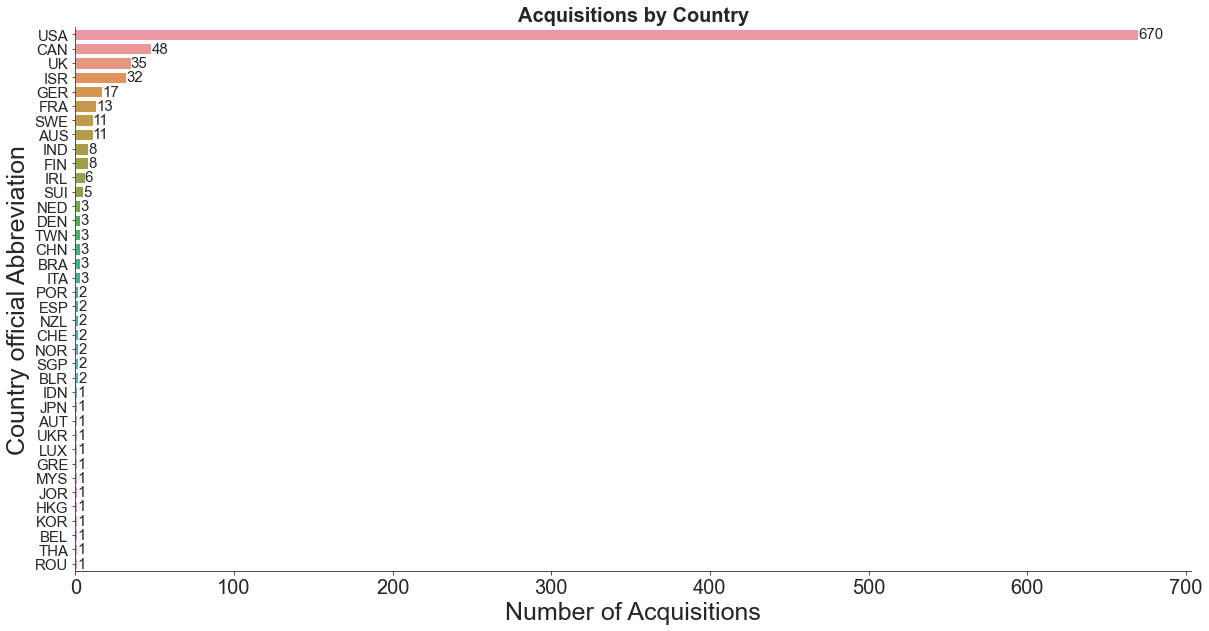

In [102]:
plt.figure(figsize=(20, 10))
ax=sns.barplot( y="Country",x='Number of Acquisitions',data=acq_by_country)
plt.title("Acquisitions by Country",fontsize=20, fontweight="bold")


plt.xlabel("Number of Acquisitions", fontsize=25)
plt.ylabel("Country official Abbreviation", fontsize=25)
sns.despine()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=10);
sns.set_style("ticks")


# code for label values. 
for container in ax.containers: 
    ax.bar_label(container,fontsize=15);


In [90]:
data.to_csv('week5projectdata.csv')

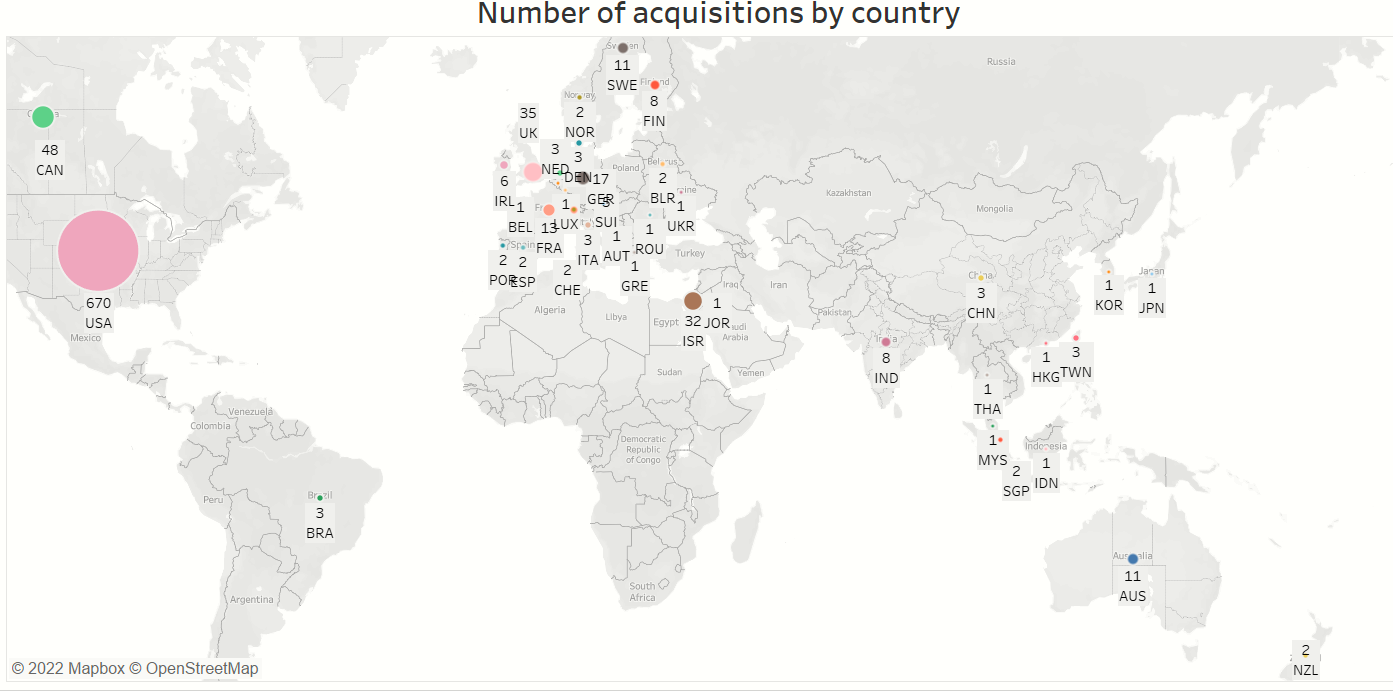

In [91]:
#data.columns

### 6) what are the business domains with  the highest acquistion value.

In [92]:
strategy=(data.groupby(['acquiring_company','derived_products','business','acquisition_year']).agg({'acquistion_price(mil_usd)':sum,'acquired_company':pd.Series.nunique})).reset_index()
strategy

,acquiring_company,derived_products,business,acquisition_year,acquistion_price(mil_usd),acquired_company
0,Apple,ARKit,Augmented reality head-mounted display,2017,30.0,1
1,Apple,ARKit,Eye tracking hardware and software,2017,0.0,1
2,Apple,ARkit,Augmented reality,2015,0.0,1
3,Apple,ARkit,Augmented reality,2016,0.0,1
4,Apple,Animoji,Realtime Motion Capture,2015,0.0,1
...,...,...,...,...,...,...
854,Yahoo,unclear,Video Conferencing,2013,0.0,1
855,Yahoo,unclear,Video Streaming Platform,2014,0.0,1
856,Yahoo,unclear,Video sharing,2013,6.5,1
857,Yahoo,unclear,Virtual world gaming,2014,0.0,1


In [93]:
strategy.to_csv('acquiring_prd_acqnumb.csv')

In [94]:
acq_bus_price=(data.groupby(['acquiring_company','business']).agg({'acquistion_price(mil_usd)':sum})).reset_index()
acq_bus_price

,acquiring_company,business,acquistion_price(mil_usd)
0,Apple,3D mapping,267.0
1,Apple,Analytics,200.0
2,Apple,App search engine,50.0
3,Apple,Application localization,12.0
4,Apple,Artificial intelligence,200.0
...,...,...,...
744,Yahoo,Weblog software,0.0
745,Yahoo,Webmail applications,20.0
746,Yahoo,Widget engine,0.0
747,Yahoo,Wireless data sharing,58.0


In [95]:
comp_spend_bybus=acq_bus_price[acq_bus_price['acquistion_price(mil_usd)']>0]
comp_spend_bybus

,acquiring_company,business,acquistion_price(mil_usd)
0,Apple,3D mapping,267.0
1,Apple,Analytics,200.0
2,Apple,App search engine,50.0
3,Apple,Application localization,12.0
4,Apple,Artificial intelligence,200.0
...,...,...,...
742,Yahoo,Web search engine,1.4
743,Yahoo,Web-based email,122.0
745,Yahoo,Webmail applications,20.0
747,Yahoo,Wireless data sharing,58.0


In [96]:
comp_spend_bybus=(comp_spend_bybus.sort_values("acquistion_price(mil_usd)", ascending=False).head(35)).reset_index()
comp_spend_bybus.head()

,index,acquiring_company,business,acquistion_price(mil_usd)
0,557,Microsoft,Professional Networking Service,26200.0
1,108,Facebook,Mobile messaging,19000.0
2,221,Google,Mobile device manufacturer,12500.0
3,582,Microsoft,Telecommunications,8500.0
4,543,Microsoft,"Mobile phones, smartphones",7200.0


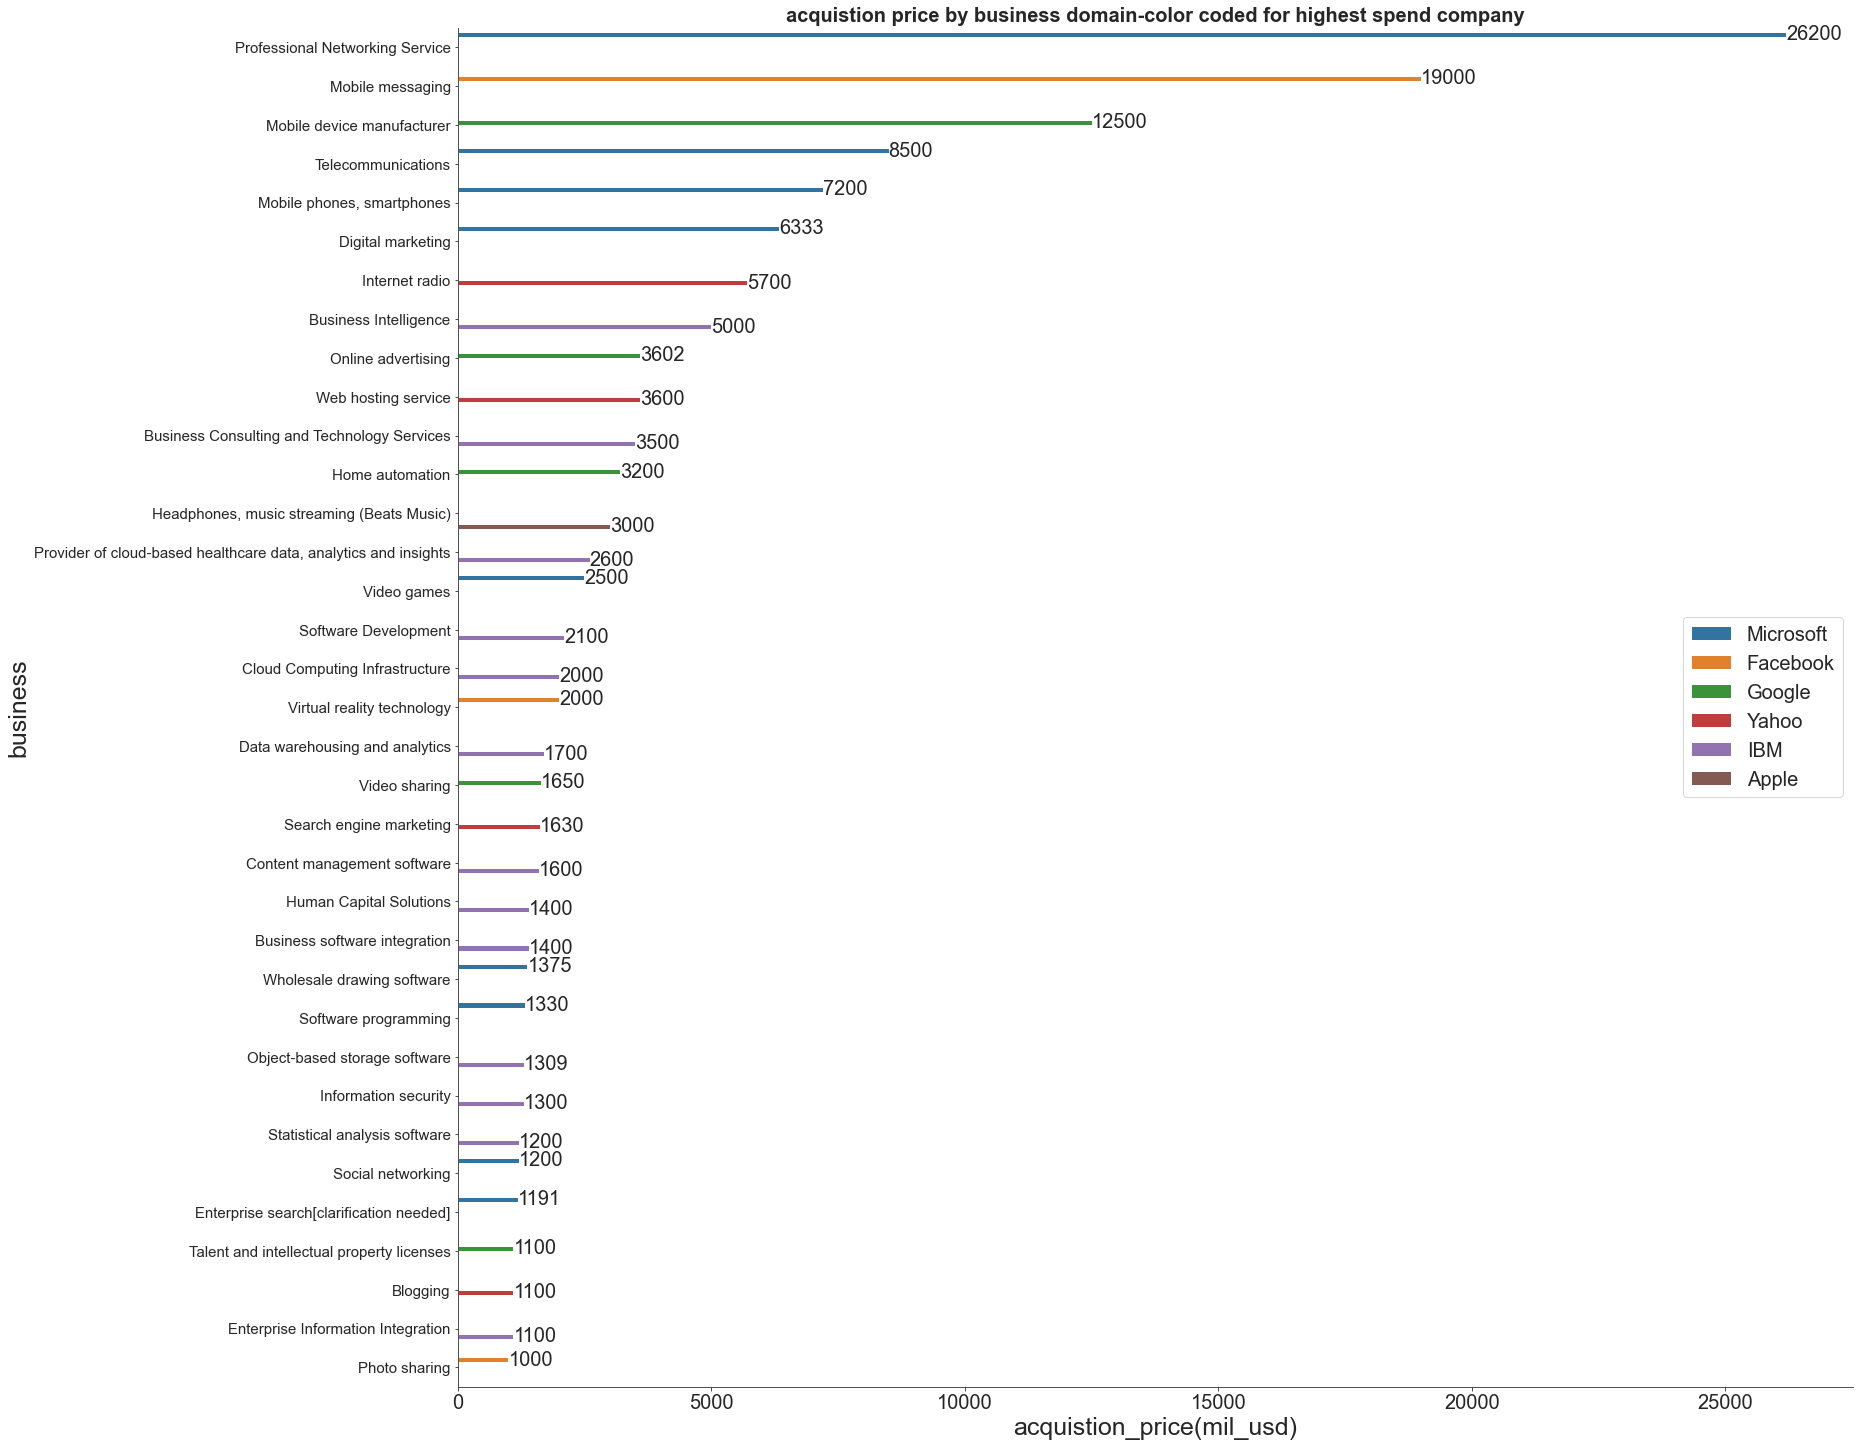

In [97]:
plt.figure(figsize=(25,25))
ax=sns.barplot(x='acquistion_price(mil_usd)', y='business', hue="acquiring_company",data=comp_spend_bybus)
plt.title('acquistion price by business domain-color coded for highest spend company',fontsize=20, fontweight="bold")
plt.xlabel('acquistion_price(mil_usd)', fontsize=25)
plt.ylabel("business", fontsize=25)

sns.despine()
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
sns.set_style("ticks")

plt.legend(prop={'size': 20}, loc=5) # legend position
for container in ax.containers: 
    ax.bar_label(container,fontsize=20)
plt.show();

The plot above clearly shows how each of the acquiring companies have a dominant going concern/dominant interest in a specific business domains. It goes to describe the current state of affairs of these acquiring companies are positining thems selves in the current time. However, it does not neccessarily reflec longer term positioning intent. 

### 7) Are the acquiring companies compete in the same arena?

In [98]:
data_crosstab = pd.crosstab(data['acquiring_company'], data['business'], margins = False)
data_crosstab

business,(Mobile) application development,.Net monitoring technology,3-D sensing technology,360-degree photography,3D Gaming,3D graphics hardware,3D mapping,3D modeling software,A/B Tester,AI-powered scheduling assistant service,...,Widget engine,Wireless,Wireless charging,Wireless data sharing,Word processor,Wunderlist to-do list applications,application virtualization software,ecommerce Analytics,internet and network optimization for wireless carriers,microLED displays
acquiring_company,,,,,,,,,,,,,,,,,,,,,
Apple,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
Facebook,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Google,0,0,0,1,0,0,0,1,0,0,...,1,1,0,0,1,0,0,0,0,0
IBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Microsoft,1,1,1,0,1,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
Twitter,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Yahoo,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [99]:
st.chi2_contingency(data_crosstab)

(4888.207274890737,
 4.472503945332496e-12,
 4230,
 array([[0.10231023, 0.10231023, 0.10231023, ..., 0.10231023, 0.10231023,
         0.10231023],
        [0.07260726, 0.07260726, 0.07260726, ..., 0.07260726, 0.07260726,
         0.07260726],
        [0.23542354, 0.23542354, 0.23542354, ..., 0.23542354, 0.23542354,
         0.23542354],
        ...,
        [0.22772277, 0.22772277, 0.22772277, ..., 0.22772277, 0.22772277,
         0.22772277],
        [0.05830583, 0.05830583, 0.05830583, ..., 0.05830583, 0.05830583,
         0.05830583],
        [0.12541254, 0.12541254, 0.12541254, ..., 0.12541254, 0.12541254,
         0.12541254]]))

In [100]:
st.chi2.ppf(0.95,df=4230)

4382.419238827069

H0: both variables are independent.
Accept H1: variables are realted.

The results of the chi square test are verified visually by a plot of the business domains by acquiring companies for low incidents of acquisition counts between 1 and 2. the competitve space gets dense confirming the chi2 results comfirming the presence of a relationship, marking a potential furture convergence of business ( on basis of new technologies) between these acquiring companies that traditionally did not compete with each other at a core level. 

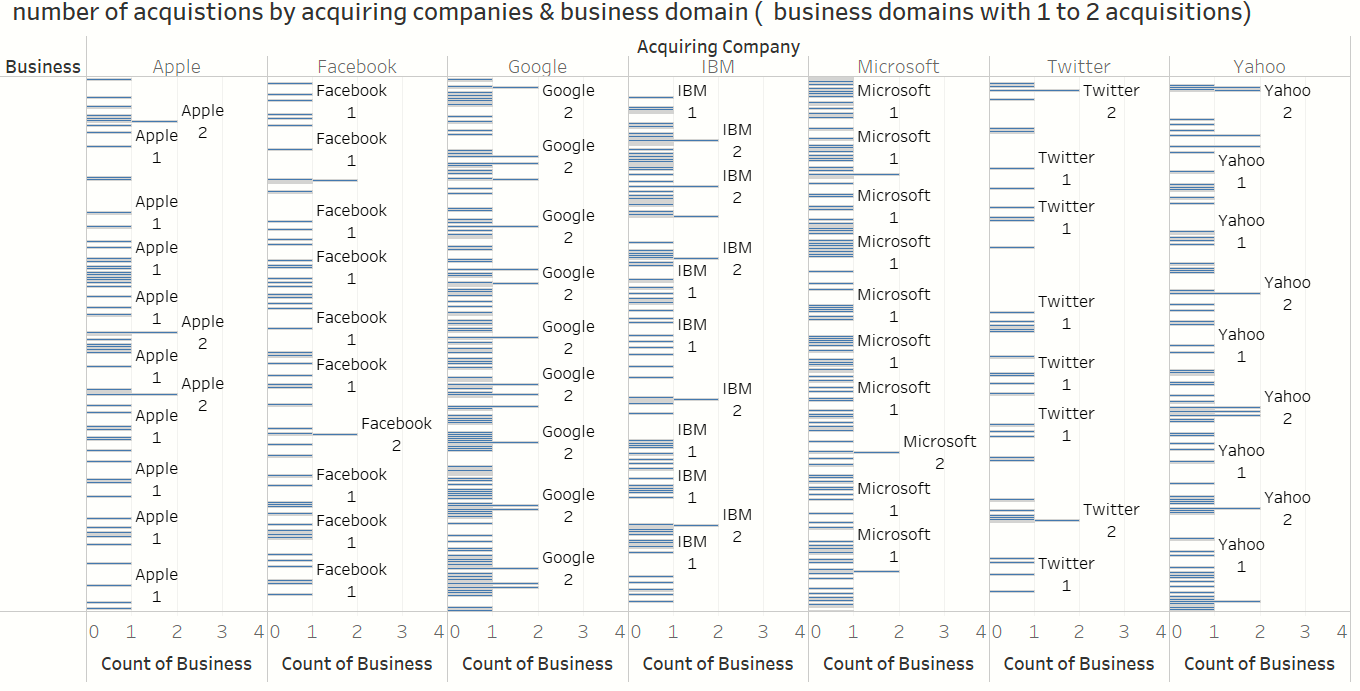

Further to the point, disecting the data in plot above, the following snapshots are some of the most notable competition grounds based on new technology trends and R&D to develop new products and services. the merger waves are more apparent here as one acquiring company trigers a response from a potential rival in a series of moves. The snapshot shots lends itself to better suggest strategic intent by these acquiring companies and what now seems to be an evitable convergence of businesses in what could be a fierce competetive arena.

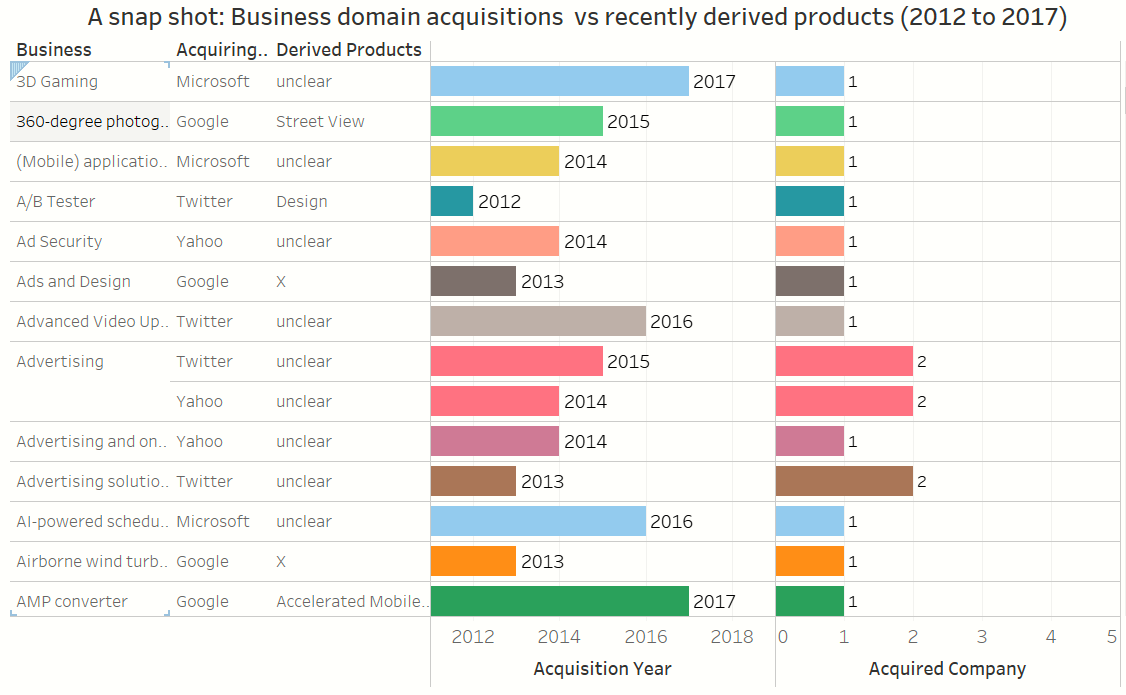
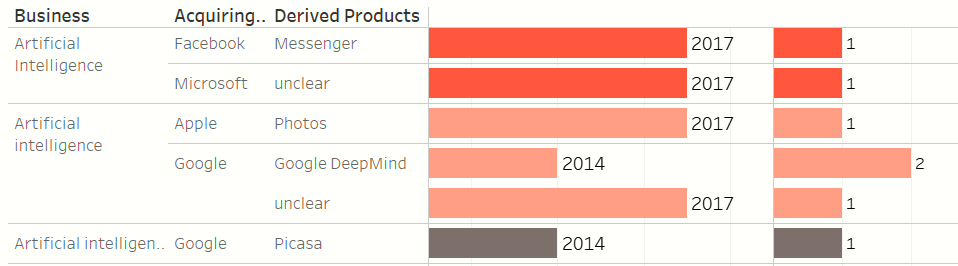
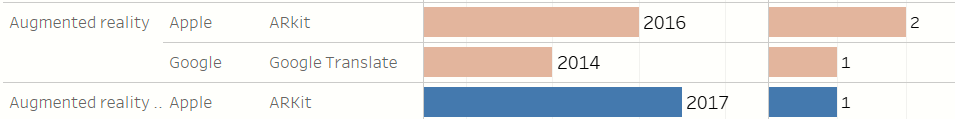
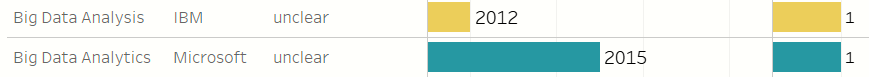
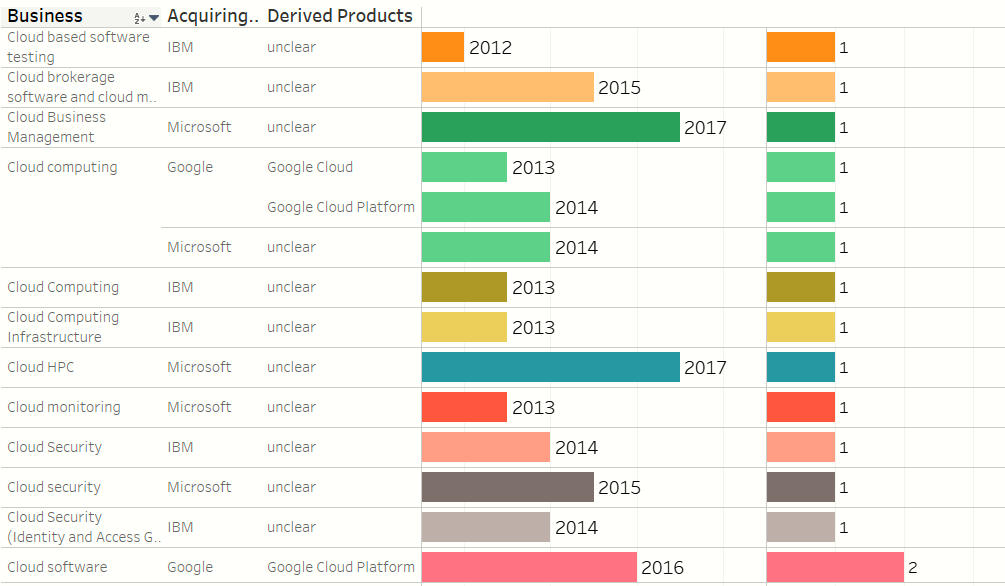
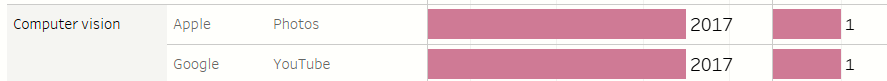
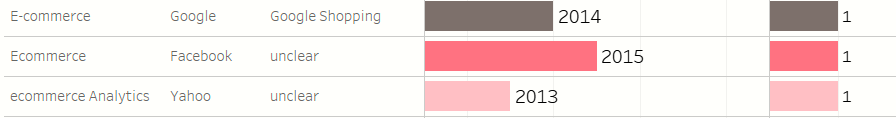
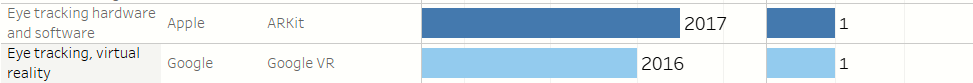
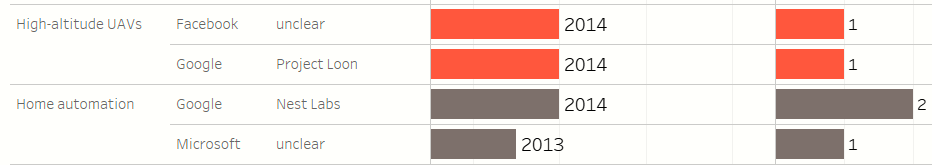

# Conclusions:

1) M&A activity has become a part of how business is done over the last 4 decades. It is not more a specialty conglomerates and holding companies(shell type or blank cheque). GAGR is about 14.1 % for the period 1987 to 2017.

2) There is some evidence in the data to support opportunistic acquisition behavior of players with a war chest as suggested by the spree in M&A activity in the years following the financial crisis. Players with a big war chest are less sensitive to major economic events especially those with handsome operating cash flows. 

3) While these players traditionally don't compete in the same space, there is evidence in the data to support merger waves triggered by potential rivals move in non legacy business domains. 

4) The number, size, type nature of acquisition along with the age of the acquiring company all reflect the  respective business models and the evolution of the strategic positioning of these acquiring players. Each of these styles has its pros and cons. For example, Apple follows an endogenous growth strategy making it more focused and less dependent on market at arms length. This is reflected through the number, size and type of acquisitions has its advantages such brand strength. Twitters seems to focus on startups typically with lower market value and huge room for an upside. The cons are clear here as manifested in the number of acquired SMEs winding up. Microsoft on the other hand is the Mercedes of the group, acquiring mature business but always getting it right ( Nokia for instance) while Google is to the likes of Airbus in this group of companies with high competence in merging and integrating acquisition to achieve a preset target. As such, the past learning and M&A history of the players as defined by their business style may aid in explaining the market sentiments and reaction to the announcement of the next acquisition. 







# Way Forward:

1) Dataframe must be updated with more recent data before an attempt is made to predict the next wave of M&A

2) The updated dataframe will further clarify the strategic intent of the players and the potential next moves

3) Investigate Bilateral relationships between these players to better understand the competitive forces between each pair. Running contingency test by pairs may shed further light on the matter. 

4) The business domains names have to be standardized and reclassified and group by broad technology disciplines to paint a better picture.

5) It is worth investigating, given a complete and updated dataset, if a model can be built to accurately predict the next merger wave ( value by domain size and potential acquirers)




The END 